In [1]:
import os
import sys
import pyrootutils

pyrootutils.setup_root(os.path.abspath(''), indicator=".project-root", pythonpath=True)
sys.path.append('..')
sys.path.append('')


In [2]:
import itertools

import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch import Tensor


## Gather Data and Batches

In [3]:
from representation.src.analysis.importance import gather_batches
from representation.src.analysis.reorder import parse_data, parse_hits


In [4]:
MODELS = [
    "encoder_only_C2C", "encoder_only_R2C", "encoder_only_E2C",
    "encoder_only_MC2C", "encoder_only_MR2C", "encoder_only_ME2C",
    "encoder_decoder_C2C", "encoder_decoder_R2C", "encoder_decoder_E2C",
    "encoder_decoder_MC2C", "encoder_decoder_MR2C", "encoder_decoder_ME2C",
    # "encoder_decoder_ME2C_64", "encoder_decoder_ME2C_128", "encoder_decoder_ME2C_256",
    # "encoder_decoder_ME2C_0_1", "encoder_decoder_ME2C_0_2", "encoder_decoder_ME2C_0_5",
    "native", "untrained",
]
TRAIN_MODEL = "encoder_decoder_ME2C_train"
METHODS=["ig", "shap","attention_maps", "rollout", "grad", "att_grad", "cat", "att_cat"]
SECTIONS=["full", "canon", "random", "no_canon", "averaged"]

ROOT = str(pyrootutils.find_root())
FILES_FOLDER = "interpretation_files"

alert_file = f"{ROOT}/data/updated_structural_alerts.csv"

data_file = f"{ROOT}/{FILES_FOLDER}/{MODELS[0]}/prediction_data.csv"
attribution_files = {f"{name}_{method}": f"{ROOT}/{FILES_FOLDER}/{name}/{method}.csv" for name in MODELS for method in METHODS}

train_data_file = f"{ROOT}/{FILES_FOLDER}/{TRAIN_MODEL}/prediction_data.csv"
train_attribution_files =  {f"{TRAIN_MODEL}_{method}": f"{ROOT}/{FILES_FOLDER}/{TRAIN_MODEL}/{method}.csv" for method in METHODS}


In [5]:
# parse data
max_rows = 14099
df = parse_data(pd.read_csv(data_file, nrows=max_rows), smiles_col="src")
df = parse_hits(df, smiles_col="src", alerts=pd.read_csv(alert_file))

raw_attributions = {
    k: torch.tensor(pd.read_csv(v, nrows=max_rows, dtype=float).values.tolist()).squeeze()
    for k, v in attribution_files.items()
}
scaled_attributions = {
    k: torch.div(v.T, v.abs().sum(dim=1)).T
    for k, v in raw_attributions.items()
}
abs_scaled_attributions = {
    k: v.abs()
    for k, v in scaled_attributions.items()
}


In [6]:
def calculate_entropy(attribution: Tensor) -> Tensor:
    normalized = attribution/torch.sum(attribution)
    entropy = -np.sum(normalized * torch.log2(normalized))
    return entropy


In [7]:
def method_mapper(
    models: list[str]=["bert", "bart", "seq", "native"],
    methods: list[str]=["ig", "shap", "attention_maps", "rollout"],
) -> dict[str, list[str]]:
    return {
        f'{name}_{method}': [name, method]
        for name, method in list(itertools.product(models, methods))
    }

def section_mapper(
    models: list[str]=["bert", "bart", "seq", "native"],
    methods: list[str]=["ig", "shap", "attention_maps", "rollout"],
    sections: list[str]=["full", "canon", "random", "no_canon"],
):
    return {
    f"{name}_{method}_{section}": [f"{name}_{method}", section]
    for name, method, section in list(itertools.product(models, methods, sections))
    }


## Select Random Molecule

In [8]:
np.random.seed(1234)
selected_id = int(np.random.choice(df["id"].to_numpy()))
selected_df = df.loc[df["id"] == selected_id]
indices = torch.tensor(selected_df.index.to_numpy())
lengths = [int(selected_df.smile_lenths.loc[ind]) for ind in indices.numpy()]
smiles = [selected_df.src.loc[ind] for ind in indices.numpy()]


In [25]:
full_batches = scaled_attributions
smile_batches = {k: gather_batches(selected_df, v, id_col="id", attr_type="smile") for k, v in full_batches.items()}
atom_batches = {k: gather_batches(selected_df, v, id_col="id", attr_type="atom") for k, v in full_batches.items()}
hit_batches = {k: gather_batches(selected_df, v, id_col="id", attr_type="alert") for k, v in full_batches.items()}

abs_full_batches = abs_scaled_attributions
abs_smile_batches = {k: gather_batches(selected_df, v, id_col="id", attr_type="smile") for k, v in abs_full_batches.items()}
abs_atom_batches = {k: gather_batches(selected_df, v, id_col="id", attr_type="atom") for k, v in abs_full_batches.items()}
abs_hit_batches = {k: gather_batches(selected_df, v, id_col="id", attr_type="alert") for k, v in abs_full_batches.items()}

selected_full_batches = {k: v[selected_id] for k, v in full_batches.items()}
selected_smile_batches = {k: v[selected_id] for k, v in smile_batches.items()}
selected_atom_batches = {k: v[selected_id] for k, v in atom_batches.items()}
selected_hit_batches = {k: v[selected_id] for k, v in hit_batches.items()}

abs_selected_full_batches = {k: v[selected_id] for k, v in abs_full_batches.items()}
abs_selected_smile_batches = {k: v[selected_id] for k, v in abs_smile_batches.items()}
abs_selected_atom_batches = {k: v[selected_id] for k, v in abs_atom_batches.items()}
abs_selected_hit_batches = {k: v[selected_id] for k, v in abs_hit_batches.items()}


## Visualize Molecules

In [26]:
from typing import Optional

import io
from PIL import Image as im2
from IPython.display import HTML, display
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps, MolDraw2DCairo
import numpy as np
from torch import Tensor

from matplotlib.pyplot import subplot_mosaic

from representation.src.analysis.smiles_visualization import smiles_importance, array_float_to_colorhex
from representation.src.analysis.distance import calculate_distances, calculate_score


In [27]:
def scale(tensor: Tensor, max: Optional[Tensor] = None) -> Tensor:
    tensor = tensor/abs(tensor).sum()
    tensor = tensor/abs(tensor).max() if max is None else tensor/max
    return tensor

def scale_and_shift(tensor: Tensor) -> Tensor:
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

def generate_mol_heatmap(smile: str, weights: list[float], dims: tuple[int, int] = (400, 200)):
    d = MolDraw2DCairo(*dims)
    _ = SimilarityMaps.GetSimilarityMapFromWeights(Chem.MolFromSmiles(smile), weights, draw2d=d, contourLines=5)
    d.FinishDrawing()
    bio = io.BytesIO(d.GetDrawingText())
    img = im2.open(bio)
    return img

def smiles_importance_fig(tokens: list[str], importance: np.ndarray, ax, y = 0):
    colors = array_float_to_colorhex(importance, 75, 75)
    assert len(tokens) == len(colors), "Importance has to match smile length"

    x = 0
    y = y
    next_y = 0
    for token, color in zip(tokens, colors):
        t = ax.text(
            x, y, token, fontdict=dict(fontsize=12),
            bbox={"facecolor": color, 'edgecolor':'none', 'pad':0.1}
        )
        t.set_transform(ax.transAxes)
        bbox = t.get_window_extent(renderer=ax.figure.canvas.get_renderer()).transformed(plt.gca().transData.inverted())
        # print(bbox)
        x += bbox.width
        next_y = max(bbox.height, next_y)

    return next_y, ax


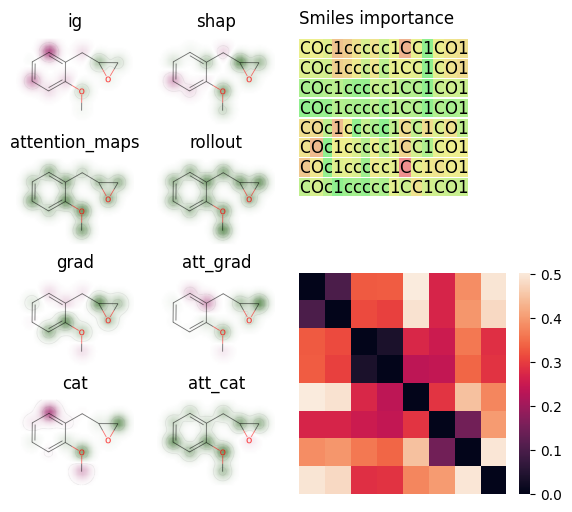

In [35]:
# Interpretation Method
model = "encoder_decoder_ME2C"
distance_method = "cosine"

# canonical only
i, index = [(i, index) for i, index in enumerate(indices)][0]
# model only
figure_atom_batches = {k: (scale(v[i])).numpy() for k, v in selected_atom_batches.items() if k.startswith(f"{model}_")}
figure_atom_batches =  {k.removeprefix(f"{model}_"): v for k, v in figure_atom_batches.items()}
figure_smile_batches = {k: ((scale(v[i])+1)/2).numpy() for k, v in selected_smile_batches.items() if k.startswith(f"{model}_")}
figure_smile_batches =  {k.removeprefix(f"{model}_"): v for k, v in figure_smile_batches.items()}
figure_imp_batches = [v for k, v in abs_selected_atom_batches.items() if k.startswith(f"{model}_")]
figure_imp_batches = torch.stack(figure_imp_batches, dim=0).view(len(figure_imp_batches), -1)
figure_distances = calculate_distances(figure_imp_batches, distance_method=distance_method, rank=False, top_k=None)

smile = smiles[i]

# Figure
mosaic = [
    ["A", "B", "Z", "."],
    ["C", "D", "Z", "."],
    ["E", "F", "X", "X"],
    ["G", "H", "X", "X"]
]
fig, axs = subplot_mosaic(mosaic, figsize=(7, 6), gridspec_kw={'width_ratios': [1,1,1,1]}) #0.8]})

# Text representation
y = 0.9
axs["Z"].set_title("Smiles importance", loc="left")
for k, attr in figure_smile_batches.items():
    next_y, _ = smiles_importance_fig([*smile], attr, axs["Z"], y)
    y = y-next_y/2
axs["Z"].axis('off')

# Heatmap
dist_df = pd.DataFrame(figure_distances.squeeze().detach().cpu().numpy())
ax = sns.heatmap(dist_df, annot=False, annot_kws={"size": 7}, cbar=True, ax=axs["X"])
axs["X"].axis('off')

# Molecule representation
axes = ["A", "B", "C", "D", "E", "F", "G", "H"]
for i, (name, attr) in enumerate(figure_atom_batches.items()):
    axs[axes[i]].imshow(np.asarray(generate_mol_heatmap(smile, [float(w) for w in attr], dims=(500, 400))))
    axs[axes[i]].set_title(name)
    axs[axes[i]].axis('off')


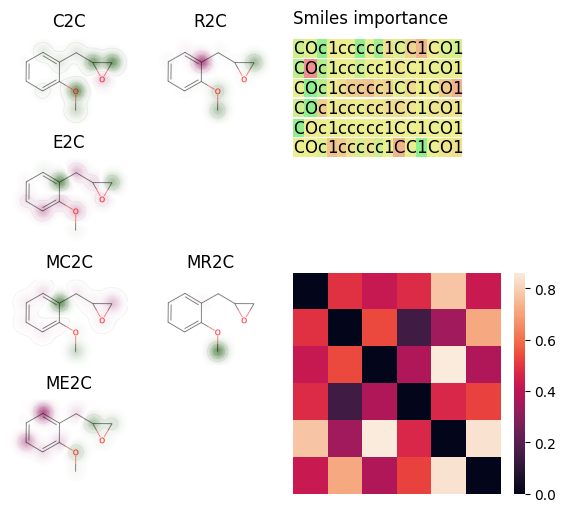

In [33]:
# Interpretation Method
method = "ig"
distance_method = "cosine"

figure_keys = [f"{model}_{method}" for model in MODELS if model.startswith("encoder_decoder")]

# canonical only
i, index = [(i, index) for i, index in enumerate(indices)][0]
# method only
figure_atom_batches = {k: (scale(v[i])).numpy() for k, v in selected_atom_batches.items() if k in figure_keys}
figure_atom_batches =  {k.removeprefix("encoder_decoder_").removesuffix(f"_{method}"): v for k, v in figure_atom_batches.items()}

figure_smile_batches = {k: ((scale(v[i])+1)/2).numpy() for k, v in selected_smile_batches.items() if k in figure_keys}
figure_smile_batches =  {k.removeprefix("encoder_decoder_").removesuffix(f"_{method}"): v for k, v in figure_smile_batches.items()}

figure_imp_batches = [v for k, v in abs_selected_atom_batches.items() if k in figure_keys]
figure_imp_batches = torch.stack(figure_imp_batches, dim=0).view(len(figure_imp_batches), -1)
figure_distances = calculate_distances(figure_imp_batches, distance_method=distance_method, rank=False, top_k=None)
smile = smiles[i]

# Figure
mosaic = [
    ["A", "B", "Z", "."],
    ["C", ".", "Z", "."],
    ["D", "E", "X", "X"],
    ["F", ".", "X", "X"]
]
fig, axs = subplot_mosaic(mosaic, figsize=(7, 6), gridspec_kw={'width_ratios': [1,1,1,1]})

# Text representation
y = 0.9
axs["Z"].set_title("Smiles importance", loc="left")
for k, attr in figure_smile_batches.items():
    next_y, _ = smiles_importance_fig([*smile], attr, axs["Z"], y)
    y = y-next_y/2
axs["Z"].axis('off')

# Heatmap
dist_df = pd.DataFrame(figure_distances.squeeze().detach().cpu().numpy())
ax = sns.heatmap(dist_df, annot=False, annot_kws={"size": 7}, cbar=True, ax=axs["X"])
axs["X"].axis('off')

# Molecule representation
axes = ["A", "B", "C", "D", "E", "F"]
for i, (name, attr) in enumerate(figure_atom_batches.items()):
    axs[axes[i]].imshow(np.asarray(generate_mol_heatmap(smile, [float(w) for w in attr], dims=(500, 400))))
    axs[axes[i]].set_title(name)
    axs[axes[i]].axis('off')


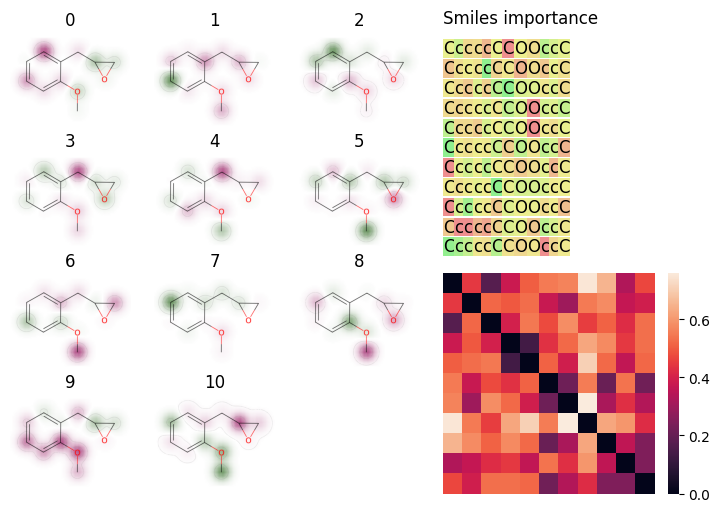

In [34]:
# Interpretation Method
model = "encoder_decoder_ME2C"
method = "ig"
distance_method = "cosine"

figure_keys = f"{model}_{method}"

# model and method only
ranges = {i for i in range(int(selected_atom_batches[figure_keys].shape[0]))}
figure_atom_batches = {i: scale(selected_atom_batches[figure_keys][i, :]).numpy() for i in ranges}
figure_smile_batches = {i: ((scale(selected_atom_batches[figure_keys][i, :])+1)/2).numpy() for i in ranges}
figure_distances = calculate_distances(abs_selected_atom_batches[figure_keys], distance_method=distance_method, rank=False, top_k=None)
smile = smiles[0]

# Enumeration
mosaic = [
    ["A", "B", "C", "Z", "."],
    ["D", "E", "F", "Z", "."],
    ["G", "H", "I", "X", "X"],
    ["J", "K", ".", "X", "X"]
]
fig, axs = subplot_mosaic(mosaic, figsize=(9, 6), gridspec_kw={'width_ratios': [1,1,1,1,1]})

# Text representation
y = 0.9
axs["Z"].set_title("Smiles importance", loc="left")
for k, attr in figure_smile_batches.items():
    next_y, _ = smiles_importance_fig([smile[i] for i in df.iloc[int(indices[0])].sorted_indices], attr, axs["Z"], y)
    y = y-next_y/2
axs["Z"].axis('off')

# Heatmap
dist_df = pd.DataFrame(figure_distances.squeeze().detach().cpu().numpy())
ax = sns.heatmap(dist_df, annot=False, annot_kws={"size": 7}, cbar=True, ax=axs["X"])
axs["X"].axis('off')

# Molecule representation
axes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]
for i, (name, attr) in enumerate(figure_atom_batches.items()):
    axs[axes[i]].imshow(np.asarray(generate_mol_heatmap(smile, [float(w) for w in attr], dims=(500, 400))))
    axs[axes[i]].set_title(name)
    axs[axes[i]].axis('off')


## Show heatmaps of strings

In [7]:
from typing import Optional

import io
from PIL import Image as im2
from IPython.display import HTML, display
from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps, MolDraw2DCairo
import numpy as np
from torch import Tensor

from matplotlib.pyplot import subplot_mosaic

from representation.src.analysis.smiles_visualization import smiles_importance, array_float_to_colorhex
from representation.src.analysis.distance import calculate_distances, calculate_score


In [13]:
def vis(smile: str, attributes: dict[str, Tensor]):
    formats = []
    max_space = max(len("encoder only"), len(smile))

    formats.append("encoder decoder")
    for _ in range(max(0, max_space-len("encoder only"))+3):
        formats.append("&nbsp")
    formats.append("encoder only")
    formats.append("<br>")


    enc_dec, enc_only, names = [], [], []
    for k, attr in attributes.items():
        if k.startswith("encoder_decoder"):
            enc_dec.append(smiles_importance(smile, importance=((scale(attr)+1)/2).numpy()))
        if k.startswith("encoder_only"):
            enc_only.append(smiles_importance(smile, importance=((scale(attr)+1)/2).numpy()))
            names.append(k.removeprefix("encoder_only_MC2C_"))
    for i, name in enumerate(names):
        formats.append(enc_only[i])
        for _ in range(max(0, max_space-len(smile))+3):
            formats.append("&nbsp")
        formats.append(enc_dec[i])
        formats.append("&nbsp"*3)
        formats.append(name)
        formats.append("<br>")
    return display(HTML("".join(formats)))


In [14]:
for i, index in enumerate(indices):
    attrs = {k: v[index,1:lengths[i]+1] for k, v in attributions.items()}
    vis(selected_df.loc[index.numpy(), "src"], attrs)


In [15]:
print(torch.index_select(attributions["encoder_decoder_MC2C_att_cat"], 0, indices)[0,1:48])
print(torch.index_select(attributions["encoder_decoder_MC2C_att_cat"], 0, indices)[0,1:20])


tensor([-0.1066,  0.0883, -0.0225,  0.2369, -0.4256, -0.3999,  0.0328,  0.0368,
        -0.6497, -0.3441,  0.0972, -0.0727,  0.0162, -0.5723,  0.0550, -0.8761,
         0.7794, -0.1342,  0.7622,  0.0156,  0.0845,  0.1113, -0.3282,  0.5065,
        -0.1728, -0.0967,  0.1598, -0.0465, -0.0918, -0.1015,  0.0478,  0.0859,
         0.0356,  0.0396,  0.3554,  0.0382, -0.2519, -0.4505, -0.1145, -0.0088,
         0.2926, -0.1221, -0.0258, -0.0916,  0.1851,  0.1054, -0.3715])
tensor([-0.1066,  0.0883, -0.0225,  0.2369, -0.4256, -0.3999,  0.0328,  0.0368,
        -0.6497, -0.3441,  0.0972, -0.0727,  0.0162, -0.5723,  0.0550, -0.8761,
         0.7794, -0.1342,  0.7622])


In [16]:
from IPython.display import HTML, display
from torch import Tensor
from typing import Optional

def scale(tensor: Tensor, max: Optional[Tensor] = None) -> Tensor:
    tensor = tensor/abs(tensor).sum()
    tensor = tensor/abs(tensor).max() if max is None else tensor/max
    return tensor

def scale_and_shift(tensor: Tensor) -> Tensor:
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

def vis(smile: str, attributes: dict[str, Tensor]) -> None:
    formats = []
    for k, attr in attributes.items():
        formats.append(smiles_importance(smile, importance=((scale(attr)+1)/2).numpy()))
        formats.append(k)
        formats.append("<br>")
    display(HTML("".join(formats)))


In [17]:
vis(selected_df.loc[11054, "src"], attrs)


In [18]:
import random
# set seed
# make random choice in the dataset
# select sample
# visualize importance of sample and display in figure
# example of bert, bart, shap, ig, attention map canon and random
